In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# load sentiment dataset
vaccine_data_sentiments = pd.read_csv('covidvaccinesentiments.csv', dtype='str', index_col=0)

In [ ]:
# remove NA values from dataset
vaccine_data_sentiments = vaccine_data_sentiments.dropna(subset=['Polarity'])

In [ ]:
vaccine_data_sentiments.shape

(1334205, 12)

In [ ]:
# split 80% training, 20% testing
split = round(len(vaccine_data_sentiments)*0.8)

In [ ]:
# allocate training and testing data and labels
train_text = vaccine_data_sentiments['full_text'][:split]
train_label = vaccine_data_sentiments['Polarity'][:split]
test_text = vaccine_data_sentiments['full_text'][split:]
test_label = vaccine_data_sentiments['Polarity'][split:]

In [ ]:
training_tweet = []
training_label = []
testing_tweet = []
testing_label = []

# convert training data to text
for row in train_text:
    training_tweet.append(str(row))
# numerically categorize training labels
for row in train_label:
    label = ['negative', 'neutral', 'positive']
    # add index as categorical label
    training_label.append(label.index(row))
# convert testing data to text
for row in test_text:
    testing_tweet.append(str(row))
# numerically categorize testing labels
for row in test_label:
    label = ['negative', 'neutral', 'positive']
    # add index as categorical label
    testing_label.append(label.index(row))

In [ ]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import regularizers

max_words = 5000 # max words in tweet
max_len = 300 # max length of tweet

In [ ]:
# initialize tokenizer with max words in tweet
tokenizer = Tokenizer(num_words=max_words)
# tokenize training tweets
tokenizer.fit_on_texts(training_tweet)
# set indices of tokenized tweets
tweet_index = tokenizer.word_index

In [ ]:
sequences = tokenizer.texts_to_sequences(training_tweet)
padded = pad_sequences(sequences, maxlen=max_len)
testing_sequences = tokenizer.texts_to_sequences(testing_tweet)
testing_padded = pad_sequences(testing_sequences, maxlen=max_len)

In [ ]:

from keras import utils

In [ ]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

embedding_dim = 20 # dimensions for embedding layer

model = Sequential()
# model1.add(layers.Embedding(max_words, 20))
model.add(layers.Embedding(max_words, embedding_dim))
# model1.add(layers.GlobalAveragePooling1D())
# model1.add(keras.layers.Dense(6, activation='relu'))

model.add(layers.LSTM(5,dropout=0.5)) # LSTM layer
model.add(layers.Dense(3,activation='softmax')) # softmax layer for multiclass classification

In [ ]:
# compile model for multlclass classification
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
# save model checkpoints in hdf5 file
checkpoint = ModelCheckpoint("sentiments_model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto',save_weights_only=False)

In [ ]:
# convert training and testing labels into numpy arrays
training_labels_final = np.array(training_label)
testing_labels_final = np.array(testing_label)

In [ ]:
# convert training and testing label numpy arrays to categorical data
training_labels_encoded = utils.to_categorical(training_labels_final, 3)
testing_labels_encoded = utils.to_categorical(testing_labels_final, 3)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 20)          100000    
                                                                 
 lstm_2 (LSTM)               (None, 5)                 520       
                                                                 
 dense_2 (Dense)             (None, 3)                 18        
                                                                 
Total params: 100,538
Trainable params: 100,538
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 20
# train model
history = model.fit(padded, training_labels_encoded, epochs=num_epochs, batch_size=2000, validation_data=(testing_padded, testing_labels_encoded), callbacks=[checkpoint])

Epoch 1/20
534/534 [==============================] - ETA: 0s - loss: 0.4560 - accuracy: 0.8493
Epoch 1: val_accuracy improved from -inf to 0.85749, saving model to sentiments_model.hdf5
534/534 [==============================] - 339s 635ms/step - loss: 0.4560 - accuracy: 0.8493 - val_loss: 0.4484 - val_accuracy: 0.8575
Epoch 2/20
534/534 [==============================] - ETA: 0s - loss: 0.4313 - accuracy: 0.8578
Epoch 2: val_accuracy improved from 0.85749 to 0.86066, saving model to sentiments_model.hdf5
534/534 [==============================] - 343s 643ms/step - loss: 0.4313 - accuracy: 0.8578 - val_loss: 0.4398 - val_accuracy: 0.8607
Epoch 3/20
534/534 [==============================] - ETA: 0s - loss: 0.4210 - accuracy: 0.8604
Epoch 3: val_accuracy improved from 0.86066 to 0.86237, saving model to sentiments_model.hdf5
534/534 [==============================] - 340s 637ms/step - loss: 0.4210 - accuracy: 0.8604 - val_loss: 0.4361 - val_accuracy: 0.8624
Epoch 4/20
534/534 [========

In [ ]:
import keras

In [ ]:
!cp sentiments_model.hdf5 /content/drive/MyDrive/AIProject

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/AIProject/sentiments_model.hdf5')

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(testing_padded, testing_labels_encoded)
print("test loss, test acc:", results)

Evaluate on test data
8339/8339 [==============================] - 177s 21ms/step - loss: 0.4185 - accuracy: 0.8701
test loss, test acc: [0.41847899556159973, 0.8700574636459351]


In [ ]:
predictions = model.predict(testing_padded)

8339/8339 [==============================] - 160s 19ms/step


In [ ]:
y_classes = [np.argmax(y, axis=None, out=None) for y in predictions]

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_classes, testing_labels_final, target_names=['negative', 'neutral', 'positive'], digits=4))

              precision    recall  f1-score   support

    negative     0.8492    0.8847    0.8666    100368
     neutral     0.9085    0.8492    0.8778     76451
    positive     0.8638    0.8715    0.8676     90022

    accuracy                         0.8701    266841
   macro avg     0.8738    0.8685    0.8707    266841
weighted avg     0.8711    0.8701    0.8702    266841



In [ ]:
%matplotlib inline

accuracy = history.history['accuracy'] # training accuracy
val_accuracy = history.history['val_accuracy'] # validation accuracy
loss = history.history['loss'] # training loss
val_loss = history.history['val_loss'] # validation loss
epochs=range(len(accuracy))

<Figure size 7200x7200 with 0 Axes>

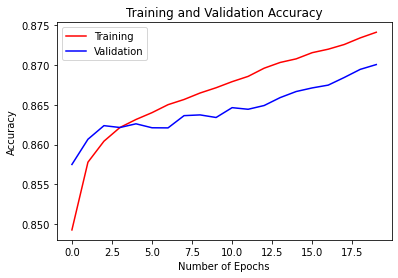

<Figure size 7200x7200 with 0 Axes>

In [ ]:
# Plotting Accuracy
plt.plot(epochs, accuracy, 'r', label='Training')
plt.plot(epochs, val_accuracy, 'b', label='Validation')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.savefig('nn_accuracy.png', dpi=300, bbox_inches='tight')
plt.figure(figsize=(100,100))

<Figure size 7200x7200 with 0 Axes>

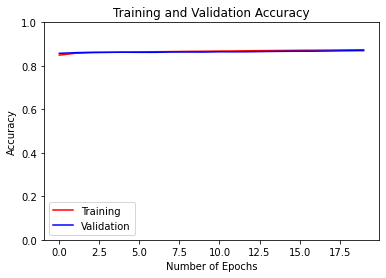

<Figure size 7200x7200 with 0 Axes>

In [ ]:
# Plotting Accuracy
plt.plot(epochs, accuracy, 'r', label='Training')
plt.plot(epochs, val_accuracy, 'b', label='Validation')
plt.legend()
plt.ylim([0,1])
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.savefig('nn_accuracy_axes.png', dpi=300, bbox_inches='tight')
plt.figure(figsize=(100,100))

<Figure size 720x720 with 0 Axes>

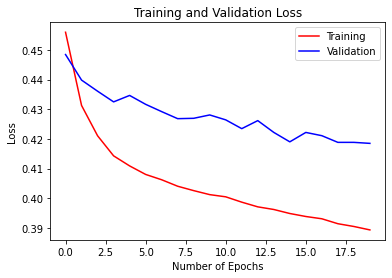

<Figure size 720x720 with 0 Axes>

In [ ]:
# Plotting Loss
plt.plot(epochs, loss, 'r', label='Training')
plt.plot(epochs, val_loss, 'b', label='Validation')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.savefig('nn_loss.png', dpi=300, bbox_inches='tight')
plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

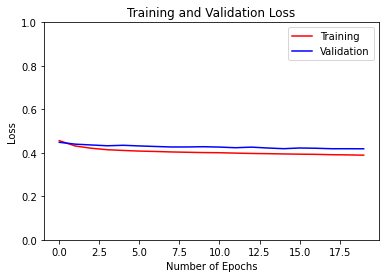

<Figure size 720x720 with 0 Axes>

In [ ]:
# Plotting Loss
plt.plot(epochs, loss, 'r', label='Training')
plt.plot(epochs, val_loss, 'b', label='Validation')
plt.legend()
plt.ylim([0,1])
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.savefig('nn_loss_axes.png', dpi=300, bbox_inches='tight')
plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

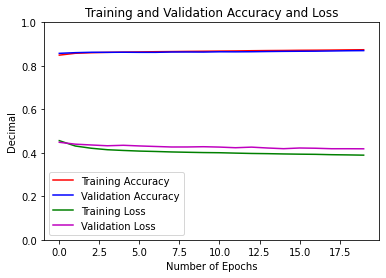

<Figure size 720x720 with 0 Axes>

In [ ]:
# Plotting Accuracy and Loss
plt.plot(epochs, accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'm', label='Validation Loss')
plt.legend()
plt.ylim([0,1])
plt.xlabel('Number of Epochs')
plt.ylabel('Decimal')
plt.title('Training and Validation Accuracy and Loss')
plt.savefig('nn_accuracy_loss.png', dpi=300, bbox_inches='tight')
plt.figure(figsize=(10,10))